# Using econohmm Container and Emission Classes to Estimate a Mixture Model

In [19]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy as sp
import numpy.random as npr
import scipy.stats as sps
from numpy import array

from pandas import Series, DataFrame 
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

import numpy.linalg as la

print sp.__version__

import os
from datetime import datetime

import econohmm.hmm as hmm
import econohmm.emission_models as emm
import econohmm.cystats as cystats

0.18.1


In [60]:
reload(emm)
reload(hmm)
reload(cystats)

<module 'econohmm.cystats' from 'econohmm/cystats.so'>

## Make Test Data

In [61]:
g1 = emm.Gauss1d()
g2 = emm.NormalInvChi2()
gr = emm.NormalInvChi2(prior='ref')

In [36]:
mu0 = array([-4,0,4, 8, 12])*2
K = mu0.shape[0]

SN =3
cov0 = 1/npr.gamma(SN /2, scale=2/SN , size=K)
# cov0 = np.ones(K)*2
print cov0
#cov0 = np.ones(K)
params0 = np.vstack((mu0, cov0)).T

[ 0.90030207  2.21057628  1.8109534   0.35243008  1.28397421]


In [37]:
e0 = emm.NormalEmission(params=params0, K=K)

In [106]:
pp = npr.randint(K,size=K).astype(float) + 1
pp /= pp.sum()

N = 1000
states = npr.choice(K, N, p=pp)
data = e0.sample_path(states, states.shape[0])
pp

array([ 0.11111111,  0.27777778,  0.22222222,  0.27777778,  0.11111111])

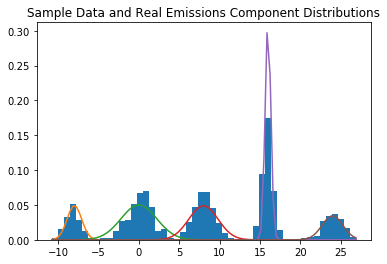

In [107]:
x = np.linspace(data.min(), data.max(), 100)
plt.hist(data, 50, normed=True);
for i, cc in enumerate(e0):
    plt.plot(x, pp[i] *sps.norm.pdf(x,cc.mu, cc.sigma))
plt.title("Sample Data and Real Emissions Component Distributions")

## Estimation Using a Standard Gibbs Sampler

In [108]:
prior = emm.NormalInvChi2()
prior.estimate(data)
prior.m0 = prior.mu
prior.s0 =  prior.sigma = 1
prior.k0 = .00001
prior.nu0 = -1
prior.hyper_param

{'k0': 1e-05, 'm0': 8.4093782253548017, 'nu0': -1, 's0': 1}

#### Initialize Gibbs Sample

In [109]:
mu1 = np.linspace(data.min(), data.max(), K)
#array([-4, 0, 4, 8, 12])
cov1 = np.ones(K)
params1 = np.vstack((mu1, cov1)).T
em1 = emm.NormalEmission(params=params1, K=K, prior=prior)

iter_num = 5000
em1.comp_hist_init(iter_num)

evidence = np.empty((K, N))
pi_prior = np.ones(K)*1./K
pi = pi_prior / pi_prior.sum()
s_count = np.empty(K)

for i, cc in enumerate(em1):
    evidence[i] = cc.evidence(data)

evidence = evidence.T
cystats.matrix_normalize(evidence)
 
sample_states = cystats.sample_states(evidence)
evidence = evidence.T

em1.components

[NormalInvChi2(mu=-10.799349,sigma=1.000000),
 NormalInvChi2(mu=-1.365599,sigma=1.000000),
 NormalInvChi2(mu=8.068152,sigma=1.000000),
 NormalInvChi2(mu=17.501903,sigma=1.000000),
 NormalInvChi2(mu=26.935654,sigma=1.000000)]

#### Run Gibbs

The sampler

In [110]:
%%time 
for i in xrange(iter_num):
    
    for j in xrange(K):
        these_states = np.where(sample_states==j)[0]
        s_count[j] = these_states.shape[0]
        em1[j].estimate(data[these_states], sample=1, i=i)
        evidence[j] = em1[j].evidence(data)
        
    pi = pi_prior + s_count
    pi /= pi.sum()
    
    evidence = evidence.T * pi
    cystats.matrix_normalize(evidence)
    sample_states = cystats.sample_states(evidence)
    evidence = evidence.T

CPU times: user 2.59 s, sys: 32.7 ms, total: 2.62 s
Wall time: 2.65 s


Estimated Components of Mixture

In [111]:
for i in xrange(K):
    em1[i].mu = em1[i].hist['mu'][100:].mean()
    em1[i].sigma = em1[i].hist['sigma'][100:].mean()
    
em1.components

[NormalInvChi2(mu=-8.201590,sigma=0.934350),
 NormalInvChi2(mu=0.187354,sigma=2.374404),
 NormalInvChi2(mu=8.050013,sigma=1.644900),
 NormalInvChi2(mu=15.945929,sigma=0.404234),
 NormalInvChi2(mu=24.042749,sigma=1.651471)]

"Real" Components of the Mixture

In [112]:
e0.components

[NormalInvChi2(mu=-8.000000,sigma=0.900302),
 NormalInvChi2(mu=0.000000,sigma=2.210576),
 NormalInvChi2(mu=8.000000,sigma=1.810953),
 NormalInvChi2(mu=16.000000,sigma=0.352430),
 NormalInvChi2(mu=24.000000,sigma=1.283974)]

#### Output for the Gibbs Sampler

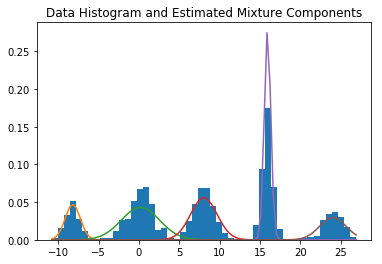

In [113]:
x = np.linspace(data.min(), data.max(), 100)

plt.hist(data, 50, normed=True);
for i, cc in enumerate(em1):
    plt.plot(x, pi[i] * sps.norm.pdf(x,cc.mu, cc.sigma))
plt.title("Data Histogram and Estimated Mixture Components")

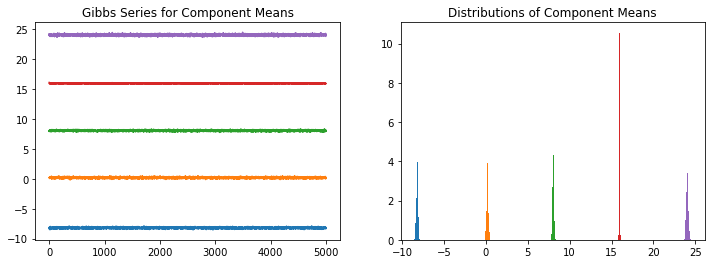

In [114]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for cc in em1:
    plt.plot(cc.hist['mu'])
plt.title("Gibbs Series for Component Means")
plt.subplot(122)
for cc in em1:
    plt.hist(cc.hist['mu'], normed=True)
plt.title("Distributions of Component Means")

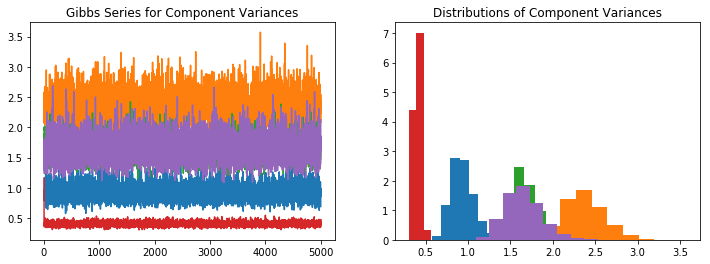

In [115]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for cc in em1:
    plt.plot(cc.hist['sigma'])
plt.title("Gibbs Series for Component Variances")
plt.subplot(122)
for cc in em1:
    plt.hist(cc.hist['sigma'], normed=True)
plt.title("Distributions of Component Variances")

## Estimate Using Expectations Maximization

Initialize a new Emissions container

In [116]:
mu2 = np.linspace(data.min(), data.max(), K)
#array([-4, 0, 4, 8, 12])
cov2 = np.ones(K)
params2 = np.vstack((mu2, cov2)).T
em2 = emm.NormalEmission(params=params1, K=K, prior=prior)

iter_num = 5000
em2.comp_hist_init(iter_num)

evidence = np.empty((K, N))
pi_prior = np.ones(K)*1./K
pi = pi_prior / pi_prior.sum()
s_count = np.empty(K)

for i, cc in enumerate(em2):
    evidence[i] = cc.evidence(data)

evidence = evidence.T
cystats.matrix_normalize(evidence)
 
sample_states = cystats.sample_states(evidence)
evidence = evidence.T


Run EM

In [117]:
for i in xrange(iter_num):
    
    for j, cc in enumerate(em2):
        cc.estimate(data, evidence[j], i=i)
        evidence[j] = cc.evidence(data)
        state_counts = evidence[j].sum()
        
    pi = state_counts * pi_prior
    pi /= pi.sum()
    
    evidence = evidence.T * pi
    cystats.matrix_normalize(evidence)
    evidence = evidence.T

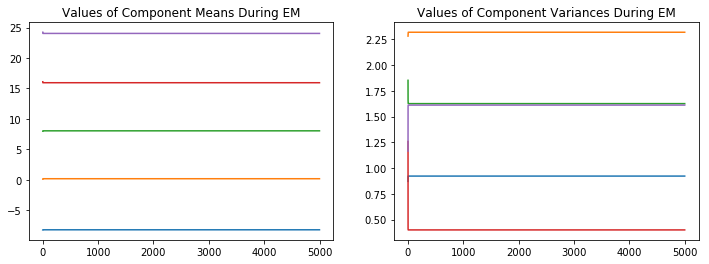

In [118]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for cc in em2:
    plt.plot(cc.hist['mu'])
plt.title("Values of Component Means During EM")
plt.subplot(122)
for cc in em2:
    plt.plot(cc.hist['sigma'])
plt.title("Values of Component Variances During EM")

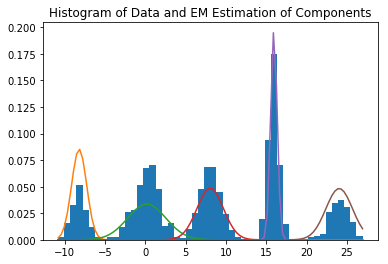

In [119]:
x = np.linspace(data.min(), data.max(), 100)
plt.hist(data, 50, normed=True);
for i, cc in enumerate(em1):
    plt.plot(x, pi[i] *sps.norm.pdf(x,cc.mu, cc.sigma))
plt.title("Histogram of Data and EM Estimation of Components")

## Estimate Dirichlet Process Mixture Model with an Unspecified Number of States

Setting Prior

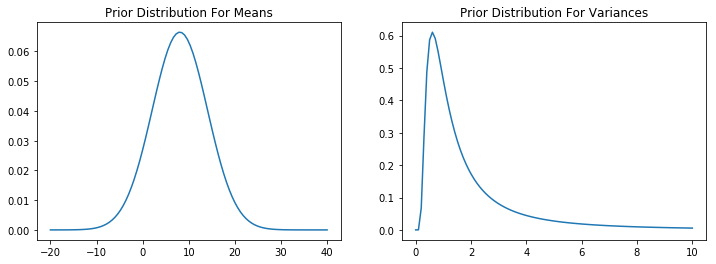

In [120]:
prior = emm.NormalInvChi2(m0=(data.max()+data.min())/2,
                         k0=.3333333/2, nu0=3)

#this needs to be a method
plt.figure(figsize=(12,4))
plt.subplot(121)
x = np.linspace(-20, 40, 100)
plt.plot(x, sps.norm.pdf(x, prior.mN, prior.sN/prior.kN))
plt.title("Prior Distribution For Means")
plt.subplot(122)
x = np.linspace(0, 10, 100)
plt.plot(x, sps.invgamma.pdf(x, prior.nuN/2, 0 ,(prior.sN *prior.nuN)/2))
plt.title("Prior Distribution For Variances")

Initialize DP Mixture Model

In [121]:
# prior.sample_posterior()
# emm.NormalInvChi2(m0=prior.mu, nu0=1, s0=prior.sigma, k0=1)

K0 = 1
Kmax = 100
iter_num = 20000
alpha = .01
a1 = 1
b1 = 10

Norms = emm.NormalEmission(K=0)
for i in xrange(Kmax):
    prior.sample_posterior()
    new_dist = emm.NormalInvChi2(m0=prior.mu, nu0=10, s0=prior.sigma, k0=1)
    new_dist.alive = False
    Norms.add_dist(new_dist)


for i in xrange(K0):
    Norms[i].alive = True
    
Norms.comp_hist_init(iter_num,atype=np.zeros)

states = npr.choice(K0, size=N)
K_live = K0
evidence = np.empty((Kmax, N))
ones = np.ones(N)

K_hist = np.empty(iter_num).astype(int)

alpha_hist = np.empty(iter_num)


Estimate DP Mixture Using Gibbs Sampler

In [122]:
%%time 
for i in xrange(iter_num):
    
    s_unique, counts = np.unique(states, return_counts=True)
    K_hist[i] = counts.shape[0]
    K_live = s_unique.max() + 1
    
    s_count = np.zeros(Kmax)    
    for s, c in zip(s_unique, counts):
        s_count[s] = c

    pi_prior = np.ones(K_live + 1) * alpha
    for j in xrange(K_live):

        if s_count[j]:
            these_states = np.where(states==j)
            Norms[j].estimate(data[these_states],sample=1, i=i)
            evidence[j] = Norms[j].evidence(data)
            pi_prior[j] += s_count[j]
            Norms[j].alive = True
        else: 
            pi_prior[j] = 0.
            Norms[j].alive = False

    pi = npr.dirichlet(pi_prior)
    
    sample_evidence = np.vstack((evidence[:K_live], ones)).T
    sample_evidence *= pi
    cystats.matrix_normalize(sample_evidence)
    states = cystats.sample_states(sample_evidence)
    


CPU times: user 14.6 s, sys: 290 ms, total: 14.9 s
Wall time: 15.2 s


View output

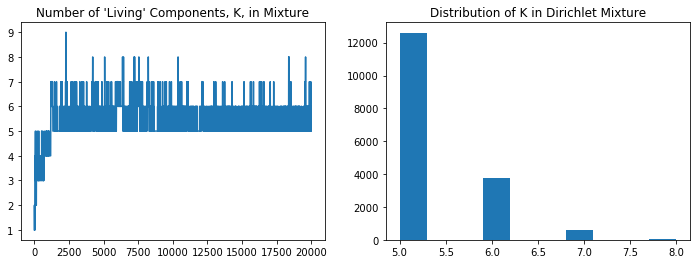

In [140]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(K_hist)
plt.title("Number of 'Living' Components, K, in Mixture")

plt.subplot(122)
plt.hist(K_hist[3000:])
plt.title("Distribution of K in Dirichlet Mixture");

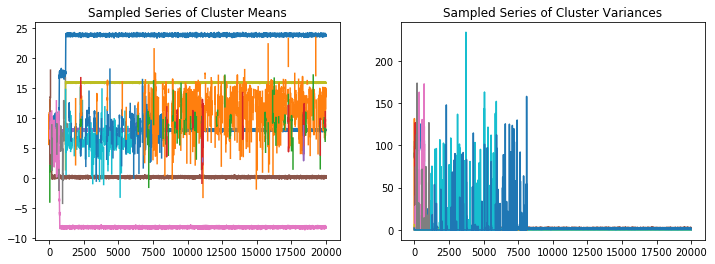

In [141]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
for i in xrange(Kmax):
    yy = (Norms[i].hist['mu'])
    yy[yy==0]= np.nan
    plt.plot(yy)
plt.title("Sampled Series of Cluster Means")

plt.subplot(122)
for i in xrange(len(pi)-1):
    yy = (Norms[i].hist['sigma'])
    plt.plot(yy)
plt.title("Sampled Series of Cluster Variances");

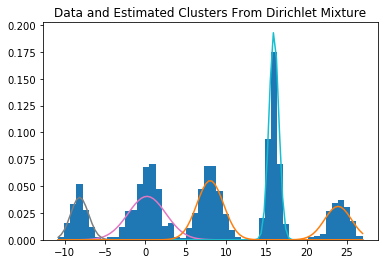

In [142]:
burnin=10000

for i in xrange(Kmax):
    Norms[i].mu =  Norms[i].hist['mu'][burnin:].mean()
    Norms[i].sigma =  Norms[i].hist['sigma'][burnin:].mean()
    
x = np.linspace(data.min(), data.max(), 100)

plt.hist(data, 50, normed=True);
for i, p in enumerate(pi):
    plt.plot(x, p * sps.norm.pdf(x, Norms[i].mu, Norms[i].sigma))
plt.title("Data and Estimated Clusters From Dirichlet Mixture");